In [ ]:
# Libraries

import os
import requests 
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tqdm import tqdm 
from zipfile import ZipFile

import sklearn
import sklearn.datasets as sklearn_datasets

from sklearn.tree import DecisionTreeClassifier

import torch
import torchvision

In [ ]:
torch.manual_seed(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Torch tensors

(tensor([ 0.0000,  2.5000,  5.0000,  7.5000, 10.0000]),
 tensor([1.0000e+00, 1.2182e+01, 1.4841e+02, 1.8080e+03, 2.2026e+04]))

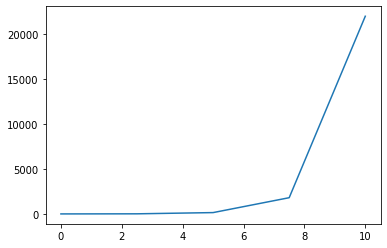

In [ ]:
x = torch.linspace(0, 10, 5)
t = torch.exp(x)

plt.plot(x.numpy(), t.numpy())
x, t

## Dot product

In [ ]:
t1, t2 = torch.tensor([2, 4]), torch.tensor([2, 4])
t1, t2, torch.dot(t1, t2), torch.dot(t1, t2.T)

(tensor([2, 4]), tensor([2, 4]), tensor(20), tensor(20))

In [ ]:
x, y = torch.arange(0, 10, 1), torch.arange(0, 10, 1)
x, y = x.view(2, 5), y.view(5, 2)
print(f"x:\n{x}\n" +
      f"y:\n{y}")

# Multiplication
# A(n, m) * B(m, k)
print(f"x @ y:\n{x @ y}\n\n" +
      f"torch.matmul:\n{torch.matmul(x, y)}")

x:
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
y:
tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])
x @ y:
tensor([[ 60,  70],
        [160, 195]])

torch.matmul:
tensor([[ 60,  70],
        [160, 195]])


## Derivatives

$f(x) = 9x^4 + 2x^3 + 3x^2 + 6x + 1$

$\frac{\partial f(x)}{x} = 36x^3 + 6x^2 + 6x^1 + 6$

In [ ]:
x = torch.tensor(2.0, requires_grad=True)
y = 9*x**4 + 2*x**3 + 3*x**2 + 6*x + 1

y.backward()
print(f"x.grad: {x.grad}\n") # Access the value 

x = torch.tensor(1.0, requires_grad=True)
z = torch.tensor(2.0, requires_grad=True)
y = x**2 + z**3

y.backward()
print(f"x.grad: {x.grad}\n" + 
      f"z.grad: {z.grad}\n")

x.grad: 330.0

x.grad: 2.0
z.grad: 12.0



## 1. Linear Model

In [ ]:
# How to use torch.nn.Linear?

model = torch.nn.Linear(in_features=1, out_features=1)
model.bias, model.weight

(Parameter containing:
 tensor([-0.4414], requires_grad=True), Parameter containing:
 tensor([[0.5153]], requires_grad=True))

In [ ]:
# Create the model

class LR(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
    def forward(self, x):
        pred = self.linear(x)
        return pred

def get_params(model):
    w, b = model.parameters()
    w, b = w.flatten(), b.flatten()
    return w.item(), b.item()

def plot_fit1(model, data):
    w, b = get_params(model)
    print(f"W:{w}\n" +
          f"b:{b}")
    x1 = np.array([-30, 30])
    y1 = w * x1 + b
    plt.plot(x1, y1, 'r', label="linear")
    plt.scatter(data[0], data[1], label="dataset")
    plt.legend()
    plt.show()

In [ ]:
# Instanciation of the model

linear = LR(input_size=1, output_size=1)
list(linear.parameters())

[Parameter containing:
 tensor([[-0.1939]], requires_grad=True), Parameter containing:
 tensor([0.4694], requires_grad=True)]

In [ ]:
# Feed the model

x1, x2 = torch.tensor([2.0]), torch.tensor([[2.0], [3.3]])
print(f"x1: {x1}\n-> model: {linear(x1)}\n")
print(f"x2: {x2}\n-> model: {linear(x2)}\n")

x1: tensor([2.])
-> model: tensor([0.0816], grad_fn=<AddBackward0>)

x2: tensor([[2.0000],
        [3.3000]])
-> model: tensor([[ 0.0816],
        [-0.1704]], grad_fn=<AddmmBackward>)



In [ ]:
# Generate dataset

X = torch.randn(100, 1) * 10
y = X + 3 * torch.randn(100, 1)

W:-0.1938614845275879
b:0.46936893463134766


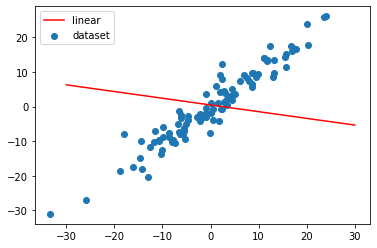

In [ ]:
plot_fit1(model=linear, data=(X, y))

Epoch_0: 170.330
Epoch_15: 9.388
Epoch_30: 9.317
Epoch_45: 9.309
Epoch_60: 9.302
Epoch_75: 9.295
Epoch_90: 9.288


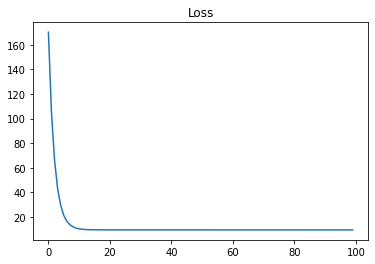

W:0.9888967275619507
b:0.4033791124820709


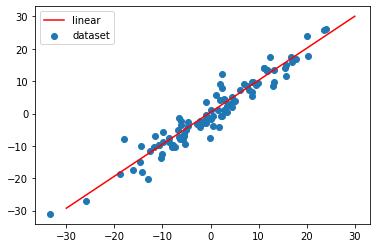

In [ ]:
# Train the model 

losses, epochs = [], 100
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params=linear.parameters(), lr=0.001)

for epoch in range(epochs):
    y_pred = linear.forward(X)
    loss   = criterion(y_pred, y)

    if epoch % 15 == 0:
        print(f"Epoch_{epoch}: {loss.item():0.3f}")
    losses.append(loss.item())

    optimizer.zero_grad()
    
    # Minimize the loss
    loss.backward()

    # Update the parameters of the model
    optimizer.step()
    
plt.title("Loss")
plt.plot(range(epochs), losses)
plt.show()

plot_fit1(model=linear, data=(X, y))

## 2. Model

In [ ]:
# Create the model

torch.manual_seed(2)

class Perceptron(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def get_params(model):
    w, b = model.parameters()
    w1, w2 = w.flatten()
    b = b.flatten()
    return w1.item(), w2.item(), b.item()

def plot_fit2(model, data):
    z1 = np.array([-2.0, 2.0])
    w1, w2, b = get_params(model)
    z2 = (w1 * z1 + b) / -w2
    plt.plot(z1, z2, 'r', label='perceptron')
    plt.scatter(data[0][data[1].flatten() == 0, 0], data[0][data[1].flatten() == 0, 1], label='Class0')
    plt.scatter(data[0][data[1].flatten() == 1, 0], data[0][data[1].flatten() == 1, 1], label='Class1') # list(zip(*X[y==0]))
    plt.legend()

In [ ]:
# Generate dataset

X, y = sklearn_datasets.make_blobs(n_samples=100, random_state=123, 
                                   centers=[[-.5, .5], [.5, -.5]], cluster_std=.4)
X, y = torch.tensor(X), torch.tensor(y.reshape(100, 1))

X.shape, y.shape

(torch.Size([100, 2]), torch.Size([100, 1]))

Epoch_0: 0.619
Epoch_200: 0.184
Epoch_400: 0.132
Epoch_600: 0.109
Epoch_800: 0.095


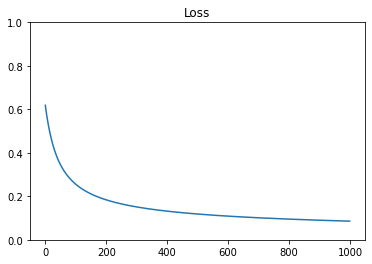

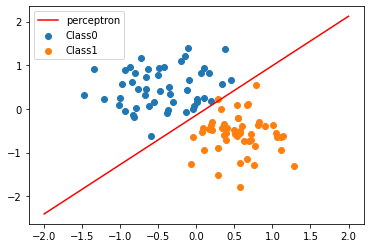

In [ ]:
# Perceptron 
perceptron = Perceptron(2, 1)
list(perceptron.parameters())

# Train the model

losses, epochs = [], 1000
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(params=perceptron.parameters(), lr=0.1)

for epoch in range(epochs):
    y_pred = perceptron.forward(X.float())
    loss   = criterion(y_pred, y.float())
    
    if not epoch % 200:
        print(f"Epoch_{epoch}: {loss.item():0.3f}")
    losses.append(loss.item())
    
    optimizer.zero_grad()

    # Minimize the loss
    loss.backward()

    # Update the parameters of the model
    optimizer.step()

plt.ylim(0, 1.)
plt.title("Loss")
plt.plot(losses)
plt.show()

plot_fit2(perceptron, data=(X, y))

## 3. Model MultilayerPerceptron

In [ ]:
torch.manual_seed(2)

class MultilayerPerceptron(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output= torch.sigmoid(self.linear1(x))
        return  torch.sigmoid(self.linear2(output))

def plot_data(X, y):
    plt.scatter(X[y.flatten()==0, 0], X[y.flatten()==0, 1])
    plt.scatter(X[y.flatten()==1, 0], X[y.flatten()==1, 1]) # list(zip(*X[y==0]))

def plot_decision_boundary(model, X, y):
    x_span = np.linspace(min(X[:, 0]) - .25, max(X[:, 0]) + .25)
    y_span = np.linspace(min(X[:, 1]) - .25, max(X[:, 1]) + .25)
    xx, yy = np.meshgrid(x_span, y_span)
    # Flatten + concat 
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    #Probability of any given point 
    pred_func = model.forward(grid)
    # The detach method we use detach to exclude any sub graphs from gradient computation
    z = pred_func.view(xx.shape).detach().numpy()
    plt.contourf(xx, yy, z)

torch.Size([500, 2]) torch.Size([500, 1])


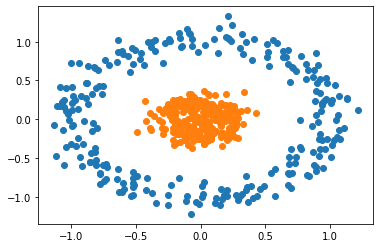

In [ ]:
# Generate data

X, y = sklearn_datasets.make_circles(n_samples=500, random_state=123, noise=.1, factor=.2)
X, y = torch.tensor(X).float(), torch.tensor(y.reshape(X.shape[0], 1)).float()

print(X.shape, y.shape)
plot_data(X, y)

In [ ]:
# Multilayer Perceptron 
multilayerperceptron = MultilayerPerceptron(2, 4, 1)
list(multilayerperceptron.parameters())

[Parameter containing:
 tensor([[ 0.1622, -0.1683],
         [ 0.1939, -0.0361],
         [ 0.3021,  0.1683],
         [-0.0813, -0.5717]], requires_grad=True), Parameter containing:
 tensor([ 0.1614, -0.6260,  0.0929,  0.0470], requires_grad=True), Parameter containing:
 tensor([[-0.1099,  0.4088,  0.0334,  0.2073]], requires_grad=True), Parameter containing:
 tensor([0.2116], requires_grad=True)]

Epoch_0: 0.715
Epoch_200: 0.017
Epoch_400: 0.006
Epoch_600: 0.003
Epoch_800: 0.002


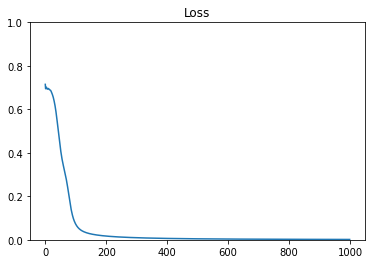

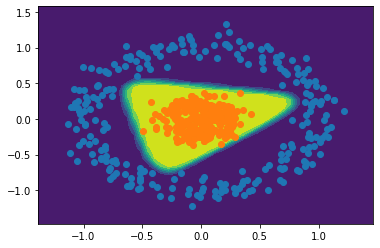

In [ ]:
# Train the model
losses, epochs = [], 1000
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=multilayerperceptron.parameters(), lr=0.1)


for epoch in range(epochs):
    y_pred = multilayerperceptron.forward(X)
    loss   = criterion(y_pred, y)
    
    if not epoch % 200:
        print(f"Epoch_{epoch}: {loss.item():0.3f}")
    losses.append(loss.item())
    
    optimizer.zero_grad()

    # Minimize the loss
    loss.backward()

    # Update the parameters of the model
    optimizer.step()

plt.ylim(0, 1.)
plt.title("Loss")
plt.plot(losses)
plt.show()

plot_decision_boundary(multilayerperceptron, X, y)
plot_data(X, y)

## MNIST

In [ ]:
# Train the model

def fit_model(classifier, epochs, training_loader, validation_loader, optimizer, criterion, which=1):

    batch_loss_train, batch_acc_train = [], []
    batch_loss_val, batch_acc_val     = [], []

    for epoch in range(epochs):

        training_loss, training_corrects     = 0, 0
        validation_loss, validation_corrects = 0, 0
    
        # Train dataset
        for x, y in training_loader:
            ### 1. Resize the input
            # y.shape: torch.Size([100]) 
            # x.shape: torch.Size([100, 1, 28, 28])
            # inputs.shape: torch.Size([100, 784])
            x = x.to(device)
            y = y.to(device)
            inputs = x.view(x.shape[0], -1) if which == 1 else x
            
            ### 2. Feed the model
            outputs = classifier(inputs)
            loss    = criterion(outputs, y)
            
            ### 3. Gradient
            optimizer.zero_grad()
            # Minimize the loss
            loss.backward()

            # Update the parameters of the model
            optimizer.step()
            
            ### 4. Calculate the loss
            training_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            training_corrects += torch.sum(preds == y)
            
        batch_loss_train.append(training_loss / len(training_loader))
        batch_acc_train.append(training_corrects.float() / len(training_loader))

        # validation dataset
        with torch.no_grad():
            for x, y in validation_loader:
                x = x.to(device)
                y = y.to(device)
                inputs = x.view(x.shape[0], -1) if which == 1 else x
                outputs = classifier(inputs)
                loss    = criterion(outputs, y)

                validation_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                validation_corrects += torch.sum(preds == y)

            batch_loss_val.append(validation_loss / len(validation_loader))
            batch_acc_val.append(validation_corrects.float() / len(validation_loader))
        if epoch % 5 == 0:   
            print(f"Epoch_{epoch}\n" +
                  f"TRAIN -> Loss: {batch_loss_train[-1]:.4f}, Acc: {batch_acc_train[-1]:.3f}\n" +
                  f"VALID -> Loss: {batch_loss_val[-1]:.4f}, Acc: {batch_acc_val[-1]:.3f}\n")   

    plt.plot(batch_loss_train, label="Train_loss")
    plt.plot(batch_loss_val, label="Valid_loss")
    plt.show()

    plt.plot(batch_acc_train, label="Train_loss")
    plt.plot(batch_acc_val, label="Valid_loss")
    plt.show()    

    return classifier, batch_loss_train, batch_loss_val, batch_acc_train, batch_acc_val


def im_convert(im_tensor):
    im = im_tensor.clone().detach().cpu().numpy() # (1, 28, 28)
    im = im.transpose(1, 2, 0) # (28, 28, 1)
    im = im * np.array((.5, .5, .5)) + np.array((.5, .5, .5)) 
    im = im.clip(0, 1)
    return im

def plot_imgs(training_loader):
    training_iter  = iter(training_loader)
    images, labels = next(training_iter)
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
        plt.imshow(im_convert(images[idx]))
        ax.set_title(labels[idx].item())
    plt.show()


In [ ]:
# Create the model

class Classifier(torch.nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size,   hidden1_size)
        self.linear2 = torch.nn.Linear(hidden1_size, hidden2_size)
        self.linear3 = torch.nn.Linear(hidden2_size, output_size)
    def forward(self, x):
        x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear2(x))
        x = self.linear3(x)
        return x        

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


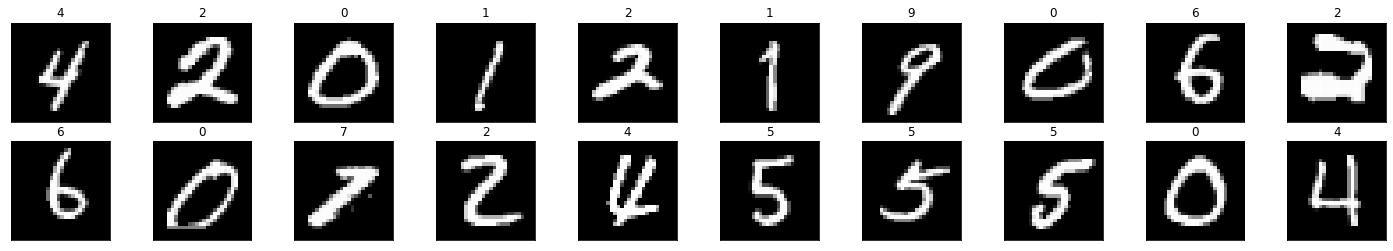

In [ ]:
# Generate data

transform = torchvision.transforms.Compose(
                [torchvision.transforms.ToTensor(), 
                 torchvision.transforms.Normalize((.5,), (.5,)) # Mean, Std
                ])

training_dataset   = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

training_loader   = torch.utils.data.DataLoader(dataset=training_dataset,   batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

plot_imgs(training_loader)

In [ ]:
# Create model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classifier = Classifier(input_size=784, hidden1_size=125, hidden2_size=65, output_size=10).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=.0001)

epochs = 15

Epoch_0
TRAIN -> Loss: 0.9362, Acc: 77.505
VALID -> Loss: 0.4207, Acc: 88.850

Epoch_10
TRAIN -> Loss: 0.1642, Acc: 95.223
VALID -> Loss: 0.1573, Acc: 95.320



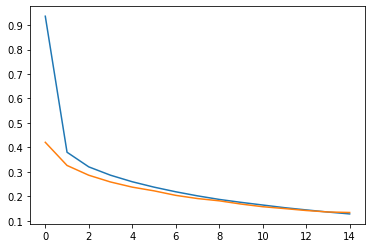

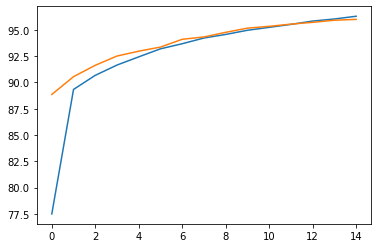

In [ ]:
# Train the model

classifier, loss_train, loss_val, acc_train, acc_val = fit_model(classifier, epochs, 
                                                                 training_loader, validation_loader, 
                                                                 optimizer, criterion, which=1)

## LeNet

In [ ]:
# Create model

class LeNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1 = torch.nn.Linear(4 * 4 * 50, 500)
        self.fc2 = torch.nn.Linear(500, 10)
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x        

In [ ]:
# Create the model

lenet = LeNet().to(device)
list(lenet.parameters())

epochs = 15
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=.0001)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch_0
TRAIN -> Loss: 0.5249, Acc: 87.320
VALID -> Loss: 0.1476, Acc: 95.710

Epoch_5
TRAIN -> Loss: 0.0433, Acc: 98.727
VALID -> Loss: 0.0366, Acc: 98.860

Epoch_10
TRAIN -> Loss: 0.0244, Acc: 99.275
VALID -> Loss: 0.0276, Acc: 99.060



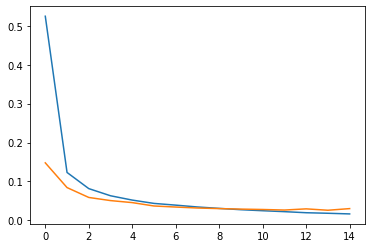

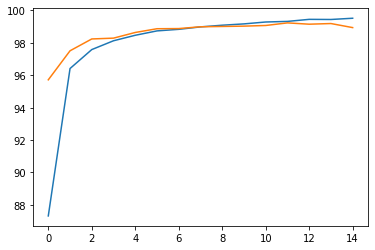

In [ ]:
lenet, loss_train, loss_val, acc_train, acc_val = fit_model(lenet, epochs, 
                                                            training_loader, validation_loader, 
                                                            optimizer, criterion, which=2)

## Decision Tree Classifier

In [ ]:
def plot_decision_boundary(X, model, h = .02):
    """
    :param h: Step size inthe mesh
    """
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),  np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    # Flatten + Concat
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.show()

In [ ]:
# Generate the data
N, D = 100, 2

X = np.random.randn(N, D)
y = np.array([0] * (N // 2) + [1] * (N // 2))

X[:N // 2] += np.array([1, 1])   # center it at (1,1)
X[N // 2:] += np.array([-1, -1]) # center it at (-1, -1)

In [ ]:
# Create the model
decisiontreeclassifier = DecisionTreeClassifier()

In [ ]:
# Fit the model
decisiontreeclassifier.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

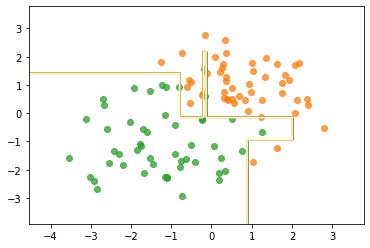

In [ ]:
# Plot the predection
plt.scatter(X[:N // 2, 0], X[:N // 2, 1], c='tab:orange', cmap='hsv', alpha=0.75)
plt.scatter(X[N // 2:, 0], X[N // 2:, 1], c='tab:green',  cmap='hsv', alpha=0.75)
plot_decision_boundary(X, decisiontreeclassifier)

## CIFAR10

In [ ]:
# Create the model

class LeNet2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1   = torch.nn.Linear(5 * 5 * 50, 500)
        self.fc2   = torch.nn.Linear(500, 10)
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 5 * 5 * 50)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


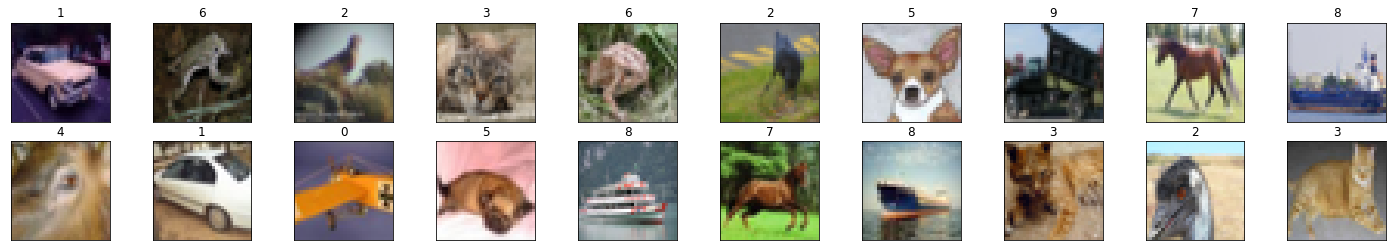

In [ ]:
# Load Data    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = torchvision.transforms.Compose(
                [torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((.5,), (.5,)) # Mean, Std
                ])

training_dataset   = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

training_loader    = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader  = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

plot_imgs(training_loader)

In [ ]:
# Instanciate the model

lenet2 = LeNet2().to(device)

epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet2.parameters(), lr=.0001)

Epoch_0
TRAIN -> Loss: 1.7735, Acc: 36.502
VALID -> Loss: 1.5748, Acc: 42.830

Epoch_5
TRAIN -> Loss: 1.1773, Acc: 58.696
VALID -> Loss: 1.1812, Acc: 58.310



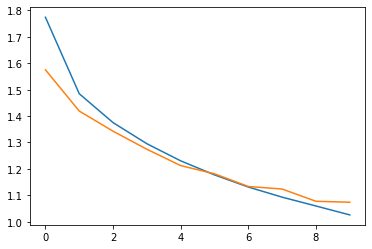

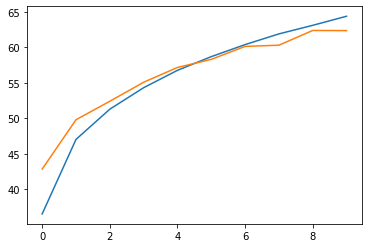

In [ ]:
# Train the model
lenet2, loss_train, loss_val, acc_train, acc_val = fit_model(lenet2, epochs, 
                                                            training_loader, validation_loader, 
                                                            optimizer, criterion, which=2)

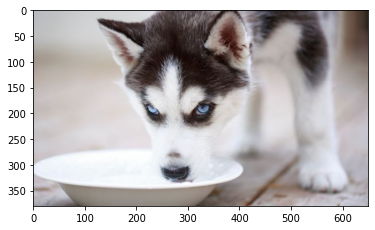

Class_5: dog


In [ ]:
# Prediction 

url = "https://resize3.prod.docfr.doc-media.fr/rcrop/650,380,center-middle/img/var/doctissimo/storage/images/fr/www/animaux/chien/alimentation-chien/quels-sont-les-besoins-en-eau-du-chien/723177-2-fre-FR/quels-sont-les-besoins-en-eau-du-chien.jpg"
img = Image.open(requests.get(url, stream=True).raw)

plt.imshow(img)
plt.show()

transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32, 32)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((.5,), (.5,)) # Mean, Std
                ])

img_t = transform(img)
# plt.imshow(im_convert(img_t)); plt.show()

output  = lenet2(img_t.unsqueeze(0).to(device))
_, pred = torch.max(output, 1)
print(f"Class_{pred.item()}: {training_dataset.classes[pred.item()]}") 

## Data augmentation + TransferLearning 


In [ ]:
### Data augmentation + TransferLearning 

def im_convert(im_tensor):
    im = im_tensor.clone().detach().numpy() # (1, 28, 28)
    im = im.transpose(1, 2, 0) # (28, 28, 1)
    im = im * np.array((.5, .5, .5)) + np.array((.5, .5, .5)) 
    im = im.clip(0, 1)
    return im

def plot_imgs(training_loader, nb: int = 20):
    training_iter  = iter(training_loader)
    images, labels = next(training_iter)
    images, labels = images.to(device), labels.to(device)
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(nb):
        ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
        plt.imshow(im_convert(images[idx]))
        ax.set_title(training_dataset.classes[labels[idx].item()])
    plt.show()
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.RandomRotation(10), #
    transforms.RandomAffine(0, shear=10, scale=(.8, 1.2)), 
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2),
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,)) # Mean, Std
    ])

############## Load Data   
print(f"Nb classe: {glob('data/ants_and_bees/train/*')}")
      
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

training_dataset   = datasets.ImageFolder("data/ants_and_bees/train", transform=transform)
validation_dataset = datasets.ImageFolder("data/ants_and_bees/val", transform=transform)

training_loader    = torch.utils.data.DataLoader(dataset=training_dataset,   batch_size=20, shuffle=True)
validation_loader  = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)

# Not enough data, but no matter, because we will use a pretrained model 
print(f"len(training_dataset): {len(training_dataset)}")
print(f"len(validation_dataset): {len(validation_dataset)}")
print(f"Image Size: {training_dataset[0][0].shape}")

plot_imgs(training_loader, nb=4)

############## Loading model
      
model = models.alexnet(pretrained=True)
print(f"model: \n {model}")

# Freeze the features
for param in model.features.parameters():
      param.requires_grad = False # (False)
# fix number of output 
n_inputs = model.classifier[6].in_features # 4096
last_layer = nn.Linear(n_inputs, len(training_dataset.classes))
model.classifier[6] = last_layer # replacing the last layer 
print(model.to(device))
      
############## Train 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
epochs = 1

batch_loss_train, batch_acc_train = [], []
batch_loss_val, batch_acc_val     = [], []

for epoch in range(epochs):
    training_loss, training_corrects     = 0, 0
    validation_loss, validation_corrects = 0, 0
    for x, y in tqdm(training_loader):
        x, y = x.to(device), y.to(device)#.unsqueeze(1)
        # torch.Size([100, 784]) torch.Size([100, 1, 28, 28])
        outputs = model(x)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        training_corrects += torch.sum(preds == y)
        
    batch_loss_train.append(training_loss / len(training_loader.dataset))
    batch_acc_train.append(training_corrects.float() / len(training_loader.dataset))

        
    with torch.no_grad():
        for x, y in tqdm(validation_loader):
            outputs = model(x)
            loss    = criterion(outputs, y)
            validation_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            validation_corrects += torch.sum(preds == y)

        batch_loss_val.append(validation_loss / len(validation_loader.dataset))
        batch_acc_val.append(validation_corrects.float() / len(validation_loader.dataset))
        
    print(f"Epoch_{epoch}")
    print(f"TRAIN -> Loss: {batch_loss_train[-1]:.4f}, Acc: {batch_acc_train[-1]:.3f}")
    print(f"VALID -> Loss: {batch_loss_val[-1]:.4f}, Acc: {batch_acc_val[-1]:.3f}")

plt.plot(batch_loss_train, label="Train_loss")
plt.plot(batch_loss_val, label="Valid_loss")
plt.legend()
plt.show()

plt.plot(batch_acc_train, label="Train_loss")
plt.plot(batch_acc_val, label="Valid_loss")
plt.legend()
plt.show()  

In [ ]:
def load_image(img_path: str, max_size: int=400, shape: int=None): 
    image = Image.open(img_path).convert("RGB")
    
    size = max_size if max(image.size) > max_size else max(image.size)
    print(f"Type_Img: {type(image)}\n" +
          f"Size_Img: {image.size}\n" +
          f"Size: {(size)}\n")
        
    in_transform = torchvision.transforms.Compose({
                    torchvision.transforms.Resize(size), 
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((.5, .5, .5), (.5, .5, .5)),
                    torchvision.transforms.Lambda(lambda x: x.unsqueeze(0))})
    
    """
        transforms.ToPILImage(), 
        transforms.Resize(size), 
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    """
    print(in_transform)
    
    return in_transform(image)

img1 = load_image(img_path=glob("./data/ants_and_bees/train/ants/*")[0])
type(img1)